In [1]:
%matplotlib inline
%load_ext tensorboard
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import glob
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
# for progress bar
from tqdm import tqdm_notebook, tqdm, trange
#to print multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# from pytorch_pretrained_vit import ViT

# from linformer import Linformer
from torch.utils.tensorboard import SummaryWriter

In [2]:
'''Helper function to customize/group the data before feeding them into pytorch'''

PATH = "/home/tzortzis/real_data/Downloads/"
EXT = "*.csv"
img_EXT = "*.png"

test_path = "/home/tzortzis/real_data/Downloads/orange/"

# writer = SummaryWriter("runs/cloth-eff-no-grid-sparse")

'Helper function to customize/group the data before feeding them into pytorch'

In [3]:
all_csv_files = []
all_img_files = []
for path, subdir, files in os.walk(PATH):
    for file in glob(os.path.join(path, EXT)):
        if file.endswith('data.csv'):
            all_csv_files.append(file)
    for i in glob(os.path.join(path, img_EXT)):
        all_img_files.append(i)


li = []

for filename in all_csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)



frame = pd.concat(li, axis=0, ignore_index=True)

In [4]:
state = frame.cloth_state.unique()
state2idx = dict((state,idx) for idx, state in enumerate(state))
idx2state = dict((idx,state) for idx,state in enumerate(state))

In [5]:
frame['label_idx'] = [state2idx[b] for b in frame.cloth_state]
frame.head()

,filename,cloth_state,false_labeling,label_idx
0,white_medium_one_hand_drop_100000,flat,NaN,0
1,white_medium_one_hand_drop_100001,flat,NaN,0
2,white_medium_one_hand_drop_100002,flat,NaN,0
3,white_medium_one_hand_drop_100003,flat,NaN,0
4,white_medium_one_hand_drop_100004,flat,NaN,0


In [6]:
frame.label_idx.unique() 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, labels_df, img_path, transform=None):
        self.labels_df = labels_df
        self.img_path = img_path
        self.transform = transform
        
        
    def __len__(self):
        return self.labels_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = self.labels_df.filename[idx]
        for file in self.img_path:
            if file.endswith(image_name + '.png'):
                img = Image.open(file)
#                 print(file)
        label = self.labels_df.label_idx[idx]
#         print(file) 
            
        if self.transform:
            img = self.transform(img)

        return img, label

In [8]:
training_dataset = CustomDataset(frame, all_img_files)

In [9]:
input_size = 224
bs = 64

In [10]:
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#these vectors is the mean and the std from the statistics in imagenet. They are always the same as far as I can recall
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
test_img = []
test_filename = []
for string in all_img_files:
    if test_path in string:
        test_img.append(string)
for f in frame.filename:
    for string in test_img:
        if f in string:
            test_filename.append(f)

In [12]:
test_frame = frame.loc[frame['filename'].isin(test_filename)].reset_index()
test_frame.cloth_state.unique()

array(['flat', 'semi-lifted-onehand', 'semi-lifted-crambled', 'crampled',
       'semi-lifted-twohands', 'lifted', 'folded', 'diagonally Folded',
       'lifted-onehand', 'semi-lifted-twohands-middle'], dtype=object)

In [13]:
frame.cloth_state.unique()

array(['flat', 'semi-lifted-onehand', 'semi-lifted-crambled', 'crampled',
       'semi-lifted-twohands', 'lifted', 'folded', 'diagonally Folded',
       'lifted-onehand', 'semi-lifted-twohands-middle'], dtype=object)

In [14]:
val_dataset = CustomDataset(test_frame, test_img, transform=data_transforms['val'])
image_dataset = {'val':val_dataset}
dataset_names = ['val']
image_dataloader = {x:DataLoader(image_dataset[x],batch_size=bs,shuffle=True,num_workers=6) for x in dataset_names}
dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

In [15]:
from efficientnet_pytorch import EfficientNet
model_ft = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [16]:
for param in model_ft.parameters():
    param.requires_grad = True    # By doing this I am keeping the parameters of the feature layers frozen so they won't update

num_fc_ftr = model_ft._fc.in_features
model_ft._fc = nn.Sequential(
    nn.Linear(num_fc_ftr, 1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1000,500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(500,10))

In [17]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam([
#     {'params':model_ft.fc.parameters()}
# ], lr=0.001)
optimizer = optim.SGD(model_ft.parameters(), lr=0.1)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.01, last_epoch=-1)

In [18]:
model_ft.load_state_dict(torch.load('/home/tzortzis/all_real_eff-finetuned-no-orange.pt'))

<All keys matched successfully>

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [20]:
model_ft.eval()  # it-disables-dropout
from torch.nn import functional as F
import torchvision.transforms.functional as TF


with torch.no_grad():
    correct = 0
    total = 0
    top_correct = 0
    phase = 'val'
    predictions = []
    preds = []
    probabilities = []
    indx = []
    top = []
    wrong_predictions = []
    wrong_images = []
    true_labels = []
    top2_pred_labels = []
    number_top = 2
    
    nb_classes = 10

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    
    for data in image_dataloader['val']:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
        inps, labels = data
        inps = inps.to(device)
        labels = labels.to(device)
        outputs = model_ft(inps)
        sm = torch.nn.Softmax()
        
        _, predicted = torch.max(outputs.data, 1)
        top2, pred_labels = torch.topk(sm(outputs.data), 2, dim=1, largest=True, sorted=True)
        top5, pred_labels5 = torch.topk(sm(outputs.data), 5, dim=1, largest=True, sorted=True)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(number_top):
            top_correct += (pred_labels5[:,i] == labels).sum().item()
            
        wrong_idx = (predicted != labels.view_as(predicted)).nonzero()[:, 0]
        wrong_samples = inps[wrong_idx]
        wrong_preds = predicted[wrong_idx]
        actual_preds = labels.view_as(predicted)[wrong_idx]
        indx.append(actual_preds)
        top.append(top2[wrong_idx])
        top2_pred_labels.append(pred_labels[wrong_idx])
        wrong_images.append(wrong_samples)
        wrong_predictions.append(wrong_preds)
        true_labels.append(actual_preds)
        
        mean=np.array([0.485, 0.456, 0.406] )
        std=np.array([0.229, 0.224, 0.225])

#         print(val_df.iloc[wrong_idx])
#         for i in range(len(wrong_idx)):
#             sample = wrong_samples[i]
#             wrong_pred = wrong_preds[i]
#             actual_pred = actual_preds[i]
#             # Undo normalization
#             sample = sample * 0.3081
#             sample = sample + 0.1307
#             sample = sample * 255.
#             sample = sample.byte()
#             img = TF.to_pil_image(sample)
#             img.save('/home/tzortzis/preds/wrong_idx{}_pred{}_actual{}.png'.format(
#                 wrong_idx[i], wrong_pred.item(), actual_pred.item()))
#             print('wrong_idx{}_pred{}_actual{}'.format(wrong_idx[i], wrong_pred.item(), actual_pred.item()))
#             print(frame.iloc(wrong_idx[i]))
        
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
#     print('Test Accuracy of the model for top: {} %'.format(100 * top_correct / total))
#     print('wrong_idx{}_pred{}_actual{}'.format(wrong_idx[i], wrong_pred.item(), actual_pred.item()))

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

/home/tzortzis/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/tzortzis/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/tzortzis/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370120218/work/torch/csrc/utils/python_arg_parser.cpp:882.)


Test Accuracy of the model: 93.16029463346194 %


In [21]:
pred_labels5

tensor([[0, 6, 3, 7, 9],
        [0, 3, 6, 7, 1],
        [4, 9, 1, 0, 5],
        [4, 9, 1, 0, 2],
        [6, 0, 4, 1, 7],
        [4, 0, 1, 9, 6],
        [1, 2, 0, 7, 4],
        [0, 6, 7, 3, 1],
        [4, 9, 0, 1, 5],
        [1, 2, 0, 7, 3],
        [1, 0, 6, 4, 2],
        [1, 0, 4, 2, 9],
        [2, 1, 3, 9, 4],
        [1, 0, 2, 4, 7],
        [0, 3, 7, 1, 6],
        [1, 2, 0, 4, 7],
        [0, 6, 4, 3, 1],
        [9, 4, 0, 2, 1],
        [0, 6, 4, 9, 1],
        [2, 1, 3, 8, 7],
        [0, 1, 6, 3, 7],
        [1, 2, 0, 7, 3],
        [8, 2, 1, 3, 0],
        [0, 6, 3, 9, 7],
        [0, 6, 3, 7, 1],
        [1, 6, 0, 3, 4],
        [2, 8, 3, 1, 0],
        [0, 3, 1, 6, 7],
        [3, 0, 6, 2, 7],
        [5, 4, 0, 8, 9],
        [0, 6, 3, 7, 1],
        [1, 7, 2, 0, 6],
        [0, 6, 3, 9, 1],
        [0, 1, 3, 7, 2],
        [1, 0, 4, 2, 9]], device='cuda:0')

In [22]:
substring = 'rectangular'
# if substring in test_path:
#     nb_classes = 9
# else:
#     nb_classes = 10

nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(image_dataloader['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                

print(confusion_matrix)

tensor([[801.,  46.,   0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.],
        [  0., 686.,  14.,   0.,   0.,   0.,  19.,   0.,   0.,   0.],
        [  0.,  13., 174.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   4., 110.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 270.,   0.,   0.,   0.,   0.,   0.],
        [ 35.,   0.,   0.,   0.,  43., 144.,   0.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   0.,   0.,   0., 113.,   0.,   0.,   0.],
        [  0.,   6.,   0.,   0.,   0.,   0.,   0.,  68.,   0.,   0.],
        [  0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,  65.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 225.]])


In [23]:
cm = confusion_matrix.numpy()
no_diag_cm_row = np.delete(cm, 7, 0)
no_diag_cm = np.delete(no_diag_cm_row, 7, 1)
no_diag_cm

array([[801.,  46.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 686.,  14.,   0.,   0.,   0.,  19.,   0.,   0.],
       [  0.,  13., 174.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   4., 110.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 270.,   0.,   0.,   0.,   0.],
       [ 35.,   0.,   0.,   0.,  43., 144.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   0.,   0., 113.,   0.,   0.],
       [  0.,   0.,   4.,   0.,   0.,   0.,   0.,  65.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 225.]],
      dtype=float32)

In [24]:
if substring in test_path:
    labels =np.asarray([
    'Flat',
    'Flat semi-lifted with one gripper',
    'Crumpled semi-lifted with one gripper',
    'Crumpled',
    'Flat semi-lifted with two grippers',
    'Lifted with two grippers',
    'Sideways Folded',
    'Lifted with one gripper',
    'Middle grasping with two grippers'])
else:
    labels =np.asarray([
        'Flat',
        'Flat semi-lifted with one gripper',
        'Crumpled semi-lifted with one gripper',
        'Crumpled',
        'Flat semi-lifted with two grippers',
        'Lifted with two grippers',
        'Sideways Folded',
        'Diagonally Folded',
        'Lifted with one gripper',
        'Middle grasping with two grippers'])

<AxesSubplot:>

Text(77.99999999999999, 0.5, 'Actual')

Text(0.5, 78.0, 'Predicted')

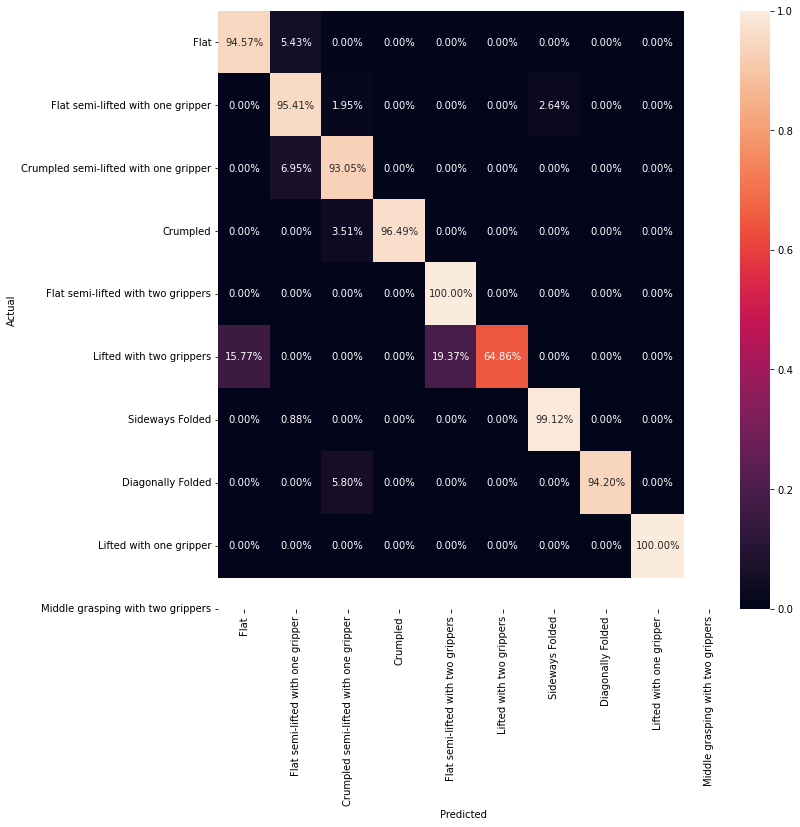

In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cmn = no_diag_cm.astype('float') / no_diag_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(cmn, annot=True, fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)